<a href="https://colab.research.google.com/github/mequanent/Music-Recommendation-Exercises/blob/main/Music%20Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying a Music Recommendation Project

In [1]:
!pip install matplotlib==3.5.0 # Need to restart the kernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install sklearn -q

In [3]:
# This cell is modified from: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7
# To install the correct version of Pytorch Geometric.
import torch

TORCH_version = torch.__version__
CUDA_version = torch.version.cuda

TORCH = TORCH_version.split('+')[0]
CUDA = 'cu' + CUDA_version.replace('.', '')

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric 

     |████████████████████████████████| 7.9 MB 41.9 MB/s 
     |████████████████████████████████| 3.5 MB 35.9 MB/s 
     |████████████████████████████████| 2.5 MB 31.1 MB/s 
     |████████████████████████████████| 750 kB 17.4 MB/s 
     |████████████████████████████████| 407 kB 16.8 MB/s 


In [ ]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

In [2]:
# Import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.dok import dok_matrix
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prep

import torch
#import torch_geometric
%matplotlib inline 

In [ ]:
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
from tqdm.notebook import tqdm

In [ ]:
print(torch.__version__)
print(torch.version.cuda)

In [3]:
source = "http://deepyeti.ucsd.edu/jianmo/amazon/index.html" # 2018 version
main_source = "https://nijianmo.github.io/amazon/index.html"

metaurl = "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Digital_Music.json.gz"
reviewurl = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Digital_Music.json.gz"
ratingurl = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music.csv"

columns = ['asin', 'reviewerID', 'rating', 'reviewTime']
rating = pd.read_csv(ratingurl, names=columns, header = None)
#meta = pd.read_json(metaurl, lines = True)
#review = pd.read_json(reviewurl, lines = True)

In [6]:
rating.head(3)

,asin,reviewerID,rating,reviewTime
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400


In [ ]:
#Create the rating matrix
rating['reviewerID'] = rating['reviewerID'].astype('category')
rating['asin'] = rating['asin'].astype('category')
R = csr_matrix((rating['rating'].values, (rating['reviewerID'].cat.codes, rating['asin'].cat.codes)))

In [ ]:
R.shape[1]

456992

In [ ]:
# 
# Convert a sparse numpy object to a sparse pytorch tensor.
def to_sparse_tensor(X):
  """
  
  Note that the tensor does not yet live on the GPU
  """
  coo = X.tocoo().astype(np.float32)
  i = torch.LongTensor(np.mat((coo.row, coo.col)))
  v = torch.FloatTensor(coo.data)
  return torch.sparse.FloatTensor(i, v, coo.shape)

In [ ]:
r = to_sparse_tensor(R)

In [ ]:
r

tensor(indices=tensor([[ 18381,  54293,  84418,  ..., 397627, 630527, 482209],
                       [     0,      0,      0,  ..., 456990, 456990, 456991]]),
       values=tensor([5., 5., 5.,  ..., 5., 5., 5.]),
       size=(840372, 456992), nnz=1516551, layout=torch.sparse_coo)

In [ ]:
rating.groupby(['rating'])['rating'].count() # Rating Distribution
rating['rating'].value_counts()

5.0    1280147
4.0     179929
3.0      57347
1.0      43108
2.0      23551
Name: rating, dtype: int64

In [7]:
# If want to ignore ratings, e.g. < 3
rating = rating[rating['rating'] > 4]
rating.rating.value_counts()

5.0    1280147
Name: rating, dtype: int64

In [11]:
rating.reviewerID.value_counts()

A1Q0BU32CVOLRA    638
A2H3JURQZOHVMB    517
AF74UAKV3Q3W0     369
A1BYA1IVKO7U79    264
A2NYK9KWFMJV4Y    263
                 ... 
A2MTJ463HP54NH      1
A272BF0Y6VHAB6      1
A1LYG3WABZDZB5      1
A2IQ5MQ8SN2TR2      1
ABNKLDCCVJKW1       1
Name: reviewerID, Length: 713286, dtype: int64

In [25]:
#df.sample(frac=0.5, replace=True, random_state=1)
#rating = rating.sample(frac=0.1, replace=True, random_state=1)
a = rating['reviewerID'].value_counts().index.tolist()[:400] # Sample the most frequent reviewers
rating = rating.loc[rating['reviewerID'].isin(a)]

In [18]:
b.reviewerID.value_counts()

A3W4D8XOGLWUN5    1326
AQ4B80F0JSBNI      682
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     535
A2H3JURQZOHVMB     526
                  ... 
A3AL8GQ69QE7WN      71
A2MV3TN2R6YA0       71
A3ADMTSOPT9QX9      70
A23PHJVJY2DFOD      70
A3DZCNEU21MB6L      70
Name: reviewerID, Length: 400, dtype: int64

In [23]:
b.rating.value_counts()

5.0    35414
4.0    10890
3.0     3458
1.0     1016
2.0     1004
Name: rating, dtype: int64

In [24]:
b.asin.value_counts()

B001KOWH0G    52
B00137ILRS    51
B00136RVG6    34
B00EH49FRE    30
B00CZF8B68    30
              ..
B00149F8AS     1
B0017WPFU0     1
B0017VPDOE     1
B0017W7EGI     1
B001TOHIYC     1
Name: asin, Length: 36915, dtype: int64

In [26]:
train, test = train_test_split(rating.values, test_size = 0.2, random_state = 16)

In [27]:
train = pd.DataFrame(train, columns = rating.columns)
test = pd.DataFrame(test, columns = rating.columns)
print(len(train), len(test), len(train)+len(test))

41425 10357 51782


In [28]:
train.head(2)

,asin,reviewerID,rating,reviewTime
0,B003LVX7JG,A27CHILBK6HIL2,4.0,1275350400
1,B001PZ2KOI,A2X7VV7HOAAJRW,4.0,1425254400


In [29]:
leu = prep.LabelEncoder()
lem = prep.LabelEncoder()

train['enc_reviewerID'] = leu.fit_transform(train['reviewerID'].values)
train['enc_asin'] = lem.fit_transform(train['asin'].values)
train.head(2)


,asin,reviewerID,rating,reviewTime,enc_reviewerID,enc_asin
0,B003LVX7JG,A27CHILBK6HIL2,4.0,1275350400,132,15000
1,B001PZ2KOI,A2X7VV7HOAAJRW,4.0,1425254400,201,12866


In [30]:
# Unique users and musics in the training set
users_train = train.reviewerID.unique()
musics_train = train.asin.unique()

# Transform the test IDs
test = test[(test['reviewerID'].isin(users_train)) & (test['asin'].isin(musics_train))]
print(len(test))

3948


In [31]:
test['enc_reviewerID'] = leu.transform(test['reviewerID'].values)
test['enc_asin'] = lem.transform(test['asin'].values)
test.head(2)

,asin,reviewerID,rating,reviewTime,enc_reviewerID,enc_asin
0,B00122K0OQ,A2VOVZMI83Y7L6,4.0,1440979200,198,6145
4,B01ESIZIJ2,AF74UAKV3Q3W0,5.0,1466208000,340,30284


In [32]:
def get_sparse(matrix):
  dok_matrx = dok_matrix.tocoo().astype(np.float32)
  values = dok_matrx.data
  indices = np.vstack((dok_matrx.row, dok_matrx.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = dok_matrx.shape

  dok_mtrx_sparse = torch.FloatTensor(i, v, torch.Size(shape))
  return dok_mtrx_sparse

In [33]:
def metrics(u_w, i_w, n_users, n_items, train, test, K):
  u_emb = nn.Embedding(u_w.size()[0], u_w.size()[1], _weight = u_w)
  i_emb = nn.Embedding(i_w.size()[0], i_w.size()[1], _weight = i_w)
  users_test = torch.LongTensor(test['enc_reviewerID'].unique())
  #musics_test = torch.LongTensor(test['enc_asin'].unique())
  relevance = torch.matmul(u_w, torch.transpose(i_w, 0, 1))

  R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
  R[train['enc_reviewerID'], train['enc_asin']] = 1.0

  R_tensor = get_sparse(R)
  R_dense = R_tensor.to_dense()

  R_dense = R_dense * (-np.inf)
  R_dense = torch.nan_to_num(R_dense, nan = 0.0)

  relevance = relevance + R_dense

  top_k_score = torch.topk(relevance, K).values
  top_k_indices = torch.topk(relevance, K).indices

  top_k_indices_df = pd.DataFrame(top_k_indices.numpy(), columns = ['top_index_'+str(x+1) for x in range(K)])

  top_k_indices_df['userID'] = top_k_indices_df.index
  top_k_indices_df['top_relevantI'] = top_k_indices_df[['top_index_'+str(x+1) for x in range(K)]].values.tolist()
  top_k_indices_df = top_k_indices_df[['userID', 'top_relevantI']]

  test_items_interact = test.groupby('enc_reviewerID')['enc_asin'].apply(list).reset_index()

  metrics_df = pd.merge(test_items_interact, top_k_indices_df, how = 'left', left_on = 'enc_reviewerID', right_on = ['userID'])
  metrics_df['intersection'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.enc_reviewerID, metrics_df.top_relevantI)]
  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intersectionon'])/len(x['enc_asin']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intersection'])/K, axis = 1)

  def get_hits(enc_musics, top_relevantI):
    return [1 if x in set(enc_musics) else 0 for x in top_relevantI]
  metrics_df['hits'] = metrics_df.apply(lambda x : get_hits(x['enc_musics'], x['top_relevantI']), axis = 1)
  def getDcgIdcg(enc_musics, hits):
    idcg = sum([1 / np.log1p(ix+1) for ix in range(min(len(enc_musics), len(hits)))])
    dcg = sum([hit/np.log1p(ix+1) for ix, hit in enumerate(hits)])
    return dcg/idcg

  def get_cummulative_sum(hits):
    return np.cumsum(hits)
  
  def getmap(enc_musics, hits, hits_cumsum):
    return sum([hit_cs*hit/(ix+1) for ix, (hit, hit_cs) in enumerate(zip(hits, hits_cumsum))])/len(enc_musics)
  
  metrics_df['ndcg'] = metrics_df.apply(lambda x : getDcgIdcg(x['enc_musics'], x['hits']), axis = 1)
  metrics_df['hits_cumsum'] = metrics_df.apply(lambda x : get_cummulative_sum(x['hits']), axis = 1)

  metrics_df['map'] = metrics_df.apply(lambda x : getmap(x['enc_musics'], x['hits'], x['hits_cumsum']), axis = 1)
  return metrics_df['recal'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()


**bookmark** 

continue from here.

In [ ]:
import random

from torch.utils.data import Dataset, DataLoader
import time
from tqdm.notebook import tqdm

In [34]:
import torch.nn as nn

In [35]:
#from torch._C import float32
class LightGCN(nn.Module):
  def __init__(self, data, n_users, n_items, n_layers, dim) -> None:
    super(LightGCN, self).__init__()
    self.data = data
    self.n_users = n_users
    self.n_items = n_items
    self.n_layers = n_layers
    self.dim = dim
    self.init_embed()
    self.norm_of_ajmat_sparse = self.get_A_tilda()
    
  def init_embed(self):
    self.E0 = nn.Embedding(self.n_users + self.n_items, self.dim)
    nn.init.xavier_uniform_(self.E0.weight)
    self.E0.weight = nn.Parameter(self.E0.weight)

  def get_A_tilda(self):
    R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
    R[self.data['enc_reviewerID'], self.data['enc_asin']] = 1.0

    adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype = np.float32)
    adj_mat = adj_mat.tolil()
    R = R.tolil()

    adj_mat[: n_users, n_users :] = R
    adj_mat[n_users :, : n_users] = R.T
    adj_mat = adj_mat.todok()

    rowsum = np.array(adj_mat.sum(1))
    d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.0
    d_mat_inv = sp.diags(d_inv)
    norm_adj_mat = d_mat_inv.dot(adj_mat)
    norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

    # Convert to Sparse matrix
    norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
    values = norm_adj_mat_coo.data
    indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = norm_adj_mat_coo.shape
    
    norm_adj_mat_sparse = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return norm_adj_mat_sparse

  def propagate(self):
    all_layers_emb = [self.E0.weight]
    emb_layer = self.E0.weight

    for layer in range(self.n_layers):
      emb_layer = torch.sparse.mm(self.norm_of_ajmat_sparse, emb_layer)
      all_layers_emb.append(emb_layer)

    all_layers_emb = torch.stack(all_layers_emb)
    mean_layers_emb = torch.mean(all_layers_emb, axis = 0)

    final_user_emb, final_item_emb = torch.split(mean_layers_emb, [num_users, n_items])
    initial_users_emb, initial_itm_emb = torch.split(self.E0.weight, [num_users, n_items])

    return final_user_emb, final_item_emb, initial_users_emb, initial_itm_emb
  
  def forward(self, users, pos_items, neg_items):
    final_user_emb, final_item_emb, initial_users_emb, initial_itm_emb = self.propagate()

    users_emb, pos_emb, neg_emb = final_user_emb[users], final_item_emb[pos_items], final_item_emb[neg_items]
    user_emb0, pos_emb0, neg_emb0 = initial_user_emb[users], initial_itm_emb[pos_items], initial_itm_emb[neg_items]

    return users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0

In [36]:
n_users = train['enc_reviewerID'].nunique()
n_items = train['enc_asin'].nunique()

In [39]:
n_layers = 3
dim = 64

lightGCN = LightGCN(train, n_users, n_items, n_layers, dim)
print("Size of Learnable Embedding: ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding:  torch.Size([31077, 64])


In [ ]:
print(review.reviewerID.nunique())
print(rating.reviewerID.nunique())
print(review.asin.nunique())
print(rating.asin.nunique())

840372
840372
456992
456992


In [ ]:
import torch
from torch.autograd import Variable

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
	# create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
	# create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)

    def forward(self, user, item):
    	# matrix multiplication
        return (self.user_factors(user)*self.item_factors(item)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [ ]:
num_users = rating.reviewerID.nunique()
num_musics = rating.asin.nunique()

model = MatrixFactorization(num_users, num_musics, n_factors=20)
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

users = rating['reviewerID'].unique()
musics = rating['asin'].unique()

for user, item in zip(users, musics):
    # get user, item and rating data
    rating = Variable(torch.FloatTensor([R[user, item]]))
    user = Variable(torch.LongTensor([int(user)]))
    item = Variable(torch.LongTensor([int(item)]))

    # predict
    prediction = model(user, item)
    loss = loss_fn(prediction, rating)

    # backpropagate
    loss.backward()

    # update weights
    optimizer.step()

IndexError: ignored

In [ ]:
num_users = rating.reviewerID.nunique()
num_musics = rating.asin.nunique()

users = rating['reviewerID'].unique()
musics = rating['asin'].unique()

user_ids = range(num_users)
music_ids = range(num_musics)

user_to_id = dict(zip(users, user_ids))
music_to_id = dict(zip(musics, music_ids))

# initialize the adjacency matrix
rat = torch.zeros(num_users, num_musics)
for index, row in rating.iterrows():
  music, user, rating = row[:3]
  if num_users != -1:
    if user not in user_to_id: break
            # create ratings matrix where (i, j) entry represents the ratings
            # of movie j given by user i.
  rat[user_to_id[user], music_to_id[music]] = rating
rat

In [ ]:
from scipy.sparse import csr_matrix

# preprocess data
USER_COL = 'reviewerID'
ITEM_COL = 'asin'
RATING_COL = 'overall'

row = review[USER_COL]
col = review[ITEM_COL]
data = review[RATING_COL]
mat = csr_matrix((data, (row, col)), shape=(users, items))
mat.eliminate_zeros()
sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity

ValueError: ignored

In [ ]:
review['reviewTime'] = pd.to_datetime(review['reviewTime'])
review['year'] = review['reviewTime'].dt.year

0          2013
1          2013
2          2013
3          2012
4          2012
           ... 
1584077    2018
1584078    2018
1584079    2017
1584080    2018
1584081    2017
Name: reviewTime, Length: 1584082, dtype: int64

In [ ]:
# Links for the 2014 version 
meta_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Digital_Music.json.gz"
ratings_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Digital_Music.csv"
reviews_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"

columns = ['reviewrId', 'musicId', 'rating', 'reviewTime']

In [ ]:
music_reviews.rename(columns = {'reviewerID':'reviewerId', 'overall':'rating', 'asin':'musicId'}, inplace = True)
music_reviews.head(2)

,reviewerId,musicId,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001"


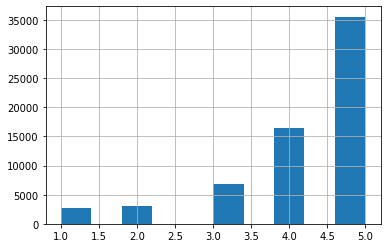

In [ ]:
music_reviews['rating'].hist()